In [28]:
import os
import cv2
import argparse
import numpy as np
import copy
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colormaps
import torch
import torch.nn.functional as F
import textwrap
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
from thinker.detect import DetectNet
import thinker.util as util
import gym, gym_csokoban

video_stats = np.load("/home/schk/RS/thinker/test/v2_dirloss-49510976-15/video_stat.npy", allow_pickle=True).item()

def gen_video(video_stats, file_path):
    import cv2

    # Generate video
    imgs = []
    hw = video_stats["real_imgs"][0].shape[1]
    reset = False
    detect = len(video_stats["detect_probs"]) > 0
    detect_col = 8 if detect else 0
    detect_probs = []
    detect_prob = 0
    real_step = -1

    for i in range(len(video_stats["real_imgs"])):        
        img = np.zeros(shape=(hw, detect_col + hw * 2, 3), dtype=np.uint8)
        real_img = np.copy(video_stats["real_imgs"][i])
        real_img = np.swapaxes(np.swapaxes(real_img, 0, 2), 0, 1)
        im_img = np.copy(video_stats["im_imgs"][i])
        im_img = np.swapaxes(np.swapaxes(im_img, 0, 2), 0, 1)
        if video_stats["status"][i] == 1:
            # reset; yellow tint
            im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
            im_img[:, :, 1] = 255 * 0.3 + im_img[:, :, 1] * 0.7
        elif video_stats["status"][i] == 3:
            # force reset; red tint
            im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
        elif video_stats["status"][i] == 0:
            # real reset; blue tint
            im_img[:, :, 2] = 255 * 0.3 + im_img[:, :, 2] * 0.7
            real_step += 1
            if detect:
                if len(video_stats["detect_probs"]) >= real_step + 1:
                    detect_prob = video_stats["detect_probs"][real_step]
                else:
                    detect_prob = 0.

        img[:, detect_col:detect_col+hw, :] = real_img
        img[:, detect_col+hw:, :] = im_img
        img = np.flip(img, 2)
        imgs.append(img)
        detect_probs.append(detect_prob)

    enlarge_fcator = 3
    width = (detect_col + hw * 2) * enlarge_fcator    
    height = hw * enlarge_fcator
    detect_col = detect_col * enlarge_fcator
    fps = 5

    path = os.path.join(file_path, "video.avi")
    fourcc = cv2.VideoWriter_fourcc(*"FFV1")
    video = cv2.VideoWriter(path, fourcc, float(fps), (width, height))
    video.set(cv2.CAP_PROP_BITRATE, 10000)  # set the video bitrate to 10000 kb/s
    for n, img in enumerate(imgs):
        height, width, _ = img.shape
        new_height, new_width = height * enlarge_fcator, width * enlarge_fcator
        resized_img = cv2.resize(
            img, (new_width, new_height), interpolation=cv2.INTER_NEAREST
        )
        if detect:
            detect_prob = detect_probs[n]
            detect_row = round(new_height * (1-detect_prob))
            if detect_row < new_height:
                plasma = colormaps.get_cmap('plasma')                
                resized_img[detect_row:, :detect_col, :] = np.array(plasma(detect_prob)[:3]) * 255.
        video.write(resized_img)
    video.release()

gen_video(video_stats, "/home/schk/tmp/")  

In [19]:
import gym_csokoban
import gym
from matplotlib import pyplot as plt
env = gym.make("cSokoban-v0", dan_num=100, seed=0)
obs = env.reset()

{'step_n': 3, 'truncated_done': False, 'dan': True}


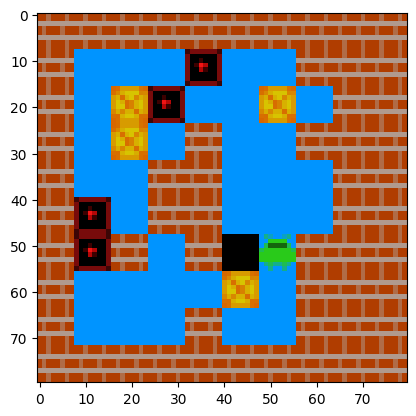

In [20]:
obs, reward, done, info = env.step(4)
plt.imshow(obs)
print(info)

Disabling frame copy for non-atari games


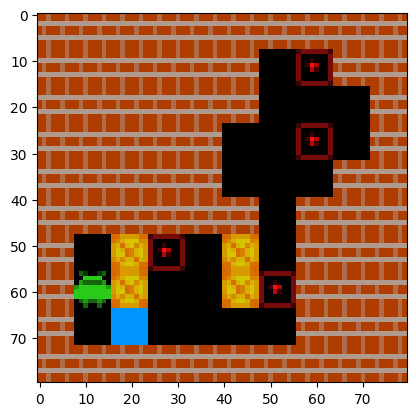

In [34]:
from thinker.env import Environment
from thinker import util
import torch

args = '--env cSokoban-v0'
flags = util.parse(args.split(" "))
env = Environment(flags, model_wrap=False, env_n=2)
env.initial()
obs = env.step(torch.tensor([0,0],dtype=int).view(1,-1, 1))
plt.imshow(torch.transpose(torch.transpose(obs.gym_env_out[0,0], 0, 2), 0, 1).detach().numpy())
for _ in range(500):
    obs = env.step(torch.tensor([0,0],dtype=int).view(1,-1, 1))
plt.imshow(torch.transpose(torch.transpose(obs.gym_env_out[0,0], 0, 2), 0, 1).detach().numpy())

In [ ]:
import torch
import thinker.util as util

import torch
import thinker.util as util

class DetectBuffer:
    def __init__(self, rec_t=20, N=5, delay_n=5):
        """
        Store training data grouped in planning stages and output
        whenever the target output is also present
            Args:
                n (int): number of planning stage per training output
                delay_n (int): number of planning stage delayed in the output y
                rec_t (int): number of step in a planning stage
        """
        self.N = N
        self.delay_n = delay_n
        self.rec_t = rec_t

        self.start_n, self.processed_n, self.data = {}, {}, {}
    
    def insert(self, xs, y, cur_t, done, id):
        """
        Args:
            xs (dict): dictionary of training input, with each elem having the
                shape of (T, B, *)            
            y (tensor): bool tensor of shape (T, B), being the target output delayed by
                delay_n planning stage
            cur_t (tensor): int tensor of shape (T), with each elem indicating the
                step in a planning stage; e.g. [1, 2, ..., 19, 0, 1, ..., 10]
            done (tensor): bool tensor of shape (T, B), being the indicator of episode end
            id (tensor): int tensor of shape (B), being the id of each input; 
                assume id is consecutive and starts with the same sets of index
        Output:
            list of training data in the form of [(train_xs, train_y), (train_xs, train_y), ...]
                with train_xs's element in shape (N, rec_t, B, *) and train_y in shape (N, B)
        """
        assert torch.all(id[1:] - id[:-1] == 1), "id tensor is not consecutively numbered"
        id = id[0].item() 
        if id not in self.start_n:
            self.start_n[id] = 0
            self.processed_n[id] = 0
            self.data[id] = []
            assert cur_t[0] == 0
        else:
            if len(self.data[id]) > 0:
                assert torch.all((self.data[id][-1]["cur_t"][-1]+1) % self.rec_t == cur_t[0]), \
                    "non consecutive cur_t received"
                
        entry = xs
        entry["y"] = y
        entry["cur_t"] = cur_t
        entry["done"] = done
        self.data[id].append(entry)
        self.processed_n[id] += torch.sum(cur_t==0).item()

        outs = []
        while(self.processed_n[id] - self.start_n[id] > self.N + self.delay_n):            
            self.start_n[id] += self.N
            outs.append(self.extract_data(id, self.N))

        return outs

    def collect_data(self, id, N, keys=None, pop=True):
        # collect the first N planning stage from data
        n = 0
        int_idx = 0
        out_list = []
        while n < N:
            top_entry = self.data[id][int_idx]
            bool_end_t = top_entry["cur_t"]==self.rec_t-1
            new_n = torch.sum(bool_end_t).item()
            if n + new_n < N:
                out_list.append(top_entry)
                n += new_n
                # pop the data
                if pop: 
                    self.data[id] = self.data[id][1:]
                else:
                    int_idx += 1
            else:
                indices = torch.nonzero(bool_end_t, as_tuple=False).squeeze() 
                indice = (indices[N - n - 1] if bool(indices.shape) else indices.item()) + 1
                out_list.append(util.dict_map(top_entry, lambda x:x[:indice]))
                n = N
                # pop the data
                if pop:
                    if indice >= top_entry["cur_t"].shape[0]:
                        self.data[id] = self.data[id][1:]
                    else:
                        self.data[id][0] = util.dict_map(top_entry, lambda x:x[indice:])

        out = {}
        for k in top_entry.keys():
            if keys is None or k in keys:
                out[k] = torch.concat([x[k] for x in out_list], dim=0)
        return out

    def extract_data(self, id, N):
        # obtain the first N planning stage and the corresponding target_y in data
        n = 0
        out = self.collect_data(id, N)
        future_out = self.collect_data(id, self.delay_n, keys=["y", "done"], pop=False)
        y = torch.concat([out["y"], future_out["y"]], dim=0)
        done = torch.concat([out["done"], future_out["done"]], dim=0)                
        
        assert out["cur_t"][0] == 0, "cur_t should start with 0"
        assert out["cur_t"].shape[0] == N*self.rec_t, \
            f" cur_t.shape is {out['cur_t'].shape}, expected {N*self.rec_t} for the first dimension."        
        assert y.shape[0] == (N + self.delay_n)*self.rec_t, \
            f" y.shape is {y.shape}, expected {(N + self.delay_n)*self.rec_t} for the first dimension."        
        
        B = y.shape[1]
        y = y.view(N + self.delay_n, self.rec_t, B)[:, 0]
        done = done.view(N + self.delay_n, self.rec_t, B)[:, 0]
        # compute target_y
        target_y = self.compute_target_y(y, done, self.delay_n, self.N)

        for k in out.keys():
            out[k] = out[k].view((N, self.rec_t) + out[k].shape[1:])

        return out, target_y
    
    def compute_target_y(self, y, done, M, N):        
        # target_y[i] = (y[i] | (~done[i+1] & y[i+1]) | (~done[i+1] & ~done[i+2] & y[i+2]) | ... | (~done[i+1] & ~done[i+2] & ... & ~done[i+M] & y[i+M]))
        B = y.shape[1]
        not_done_cum = torch.ones(M, N, B, dtype=bool, device=done.device)
        target_y = y.clone()[:-M]
        not_done_cum[0] = ~done[1:1+N]
        target_y = target_y | (not_done_cum[0] & y[1:1+N])
        for m in range(1, M):
            not_done_cum[m] = not_done_cum[m-1] & ~done[m+1:m+1+N]
            target_y = target_y | (not_done_cum[m] & y[m+1:m+1+N])
        return target_y


rec_t = 4
N = 2
delay_n = 5
B = 2
T = 13

detect_buffer = DetectBuffer(rec_t=rec_t, N=N, delay_n=delay_n)

cur_ts = torch.arange(rec_t).repeat(T * 10)
xs = torch.rand(T * 10, B, 2)
ys = torch.randint(0, 2, (T * 10, B)).bool()
dones = torch.zeros(T * 10, B).bool()
id = torch.arange(B)
#dones = torch.randint(0, 2, (T * 10, B)).bool()

out_ys = []
m = 0
for n in range(10):
    x = {"x": xs[n*T:(n+1)*T]}
    outs = detect_buffer.insert(x, ys[n*T:(n+1)*T], cur_ts[n*T:(n+1)*T], dones[n*T:(n+1)*T], id)
    for out in outs:     
        print(torch.all(out[0]["x"] == xs[m * N * rec_t:(m + 1) * N * rec_t].view(N, rec_t, B, -1)))
        out_ys.append(out[1])
        m += 1

print("true y", ys[:rec_t*20].view(-1, rec_t, B)[:,0])        
print("target y", out_ys)

In [230]:
from thinker.net import FrameEncoder
from torch import nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 500):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:,:x.size(1)]
        return x

class DetectFrameEncoder(nn.Module):
    def __init__(
        self,
        pred_x_shape,        
        out_size=128,
    ):  
        super(DetectFrameEncoder, self).__init__()
        self.out_size = out_size
        self.encoder = FrameEncoder(num_actions=None,
                                    input_shape=pred_x_shape,
                                    size_nn=1,
                                    downscale_c=4,
                                    concat_action=False)
        
        self.conv = []
        in_ch =  self.encoder.out_shape[0]
        for ch in [64, 32]:
            self.conv.append(nn.ReLU())
            self.conv.append(nn.Conv2d(in_channels=in_ch,
                                       out_channels=ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1,))
            in_ch = ch
        self.conv = nn.Sequential(*self.conv)
        conv_out_size = in_ch * self.encoder.out_shape[1] * self.encoder.out_shape[2]
        self.fc = nn.Sequential(nn.Linear(conv_out_size, self.out_size))       

    def forward(self, x):
        # x in shape of (B, C, H, W)
        out = self.encoder(x)
        out = self.conv(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out                                
        
class DetectNetwork(nn.Module):
    def __init__(
        self,
        pred_x_shape,
        model_out_shape,
        num_actions,
    ):    
        super(DetectNetwork, self).__init__()
        
        self.pred_x_shape = pred_x_shape # in (C, H, W) 
        self.model_out_shape = model_out_shape # in (C,) 
        self.num_actions = num_actions

        self.enc_out_size = 128        
        tran_nhead = 8
        reminder = tran_nhead - ((self.enc_out_size + model_out_shape[0] + num_actions + 1) % tran_nhead)
        self.enc_out_size += reminder
        self.true_x_encoder = DetectFrameEncoder(pred_x_shape=pred_x_shape, out_size=self.enc_out_size)
        self.pred_x_encoder = DetectFrameEncoder(pred_x_shape=pred_x_shape, out_size=self.enc_out_size)

        self.embed_size = self.enc_out_size + model_out_shape[0] + num_actions + 1
        self.pos_encoder = PositionalEncoding(self.embed_size)

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_size, 
                                                   nhead=tran_nhead, 
                                                   dim_feedforward=512,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 3)
        self.classifier = nn.Linear(self.embed_size, 1)

        self.beta = nn.Parameter(torch.tensor(0.5), requires_grad=False) # portion of negative class

    def forward(self, pred_x, model_out, action, reset):
        """
        Forward pass of detection nn
        Args:
            pred_x: float Tensor in shape of (N, B, rec_t, C, H, W); true and predicted frame
            model_out: float Tensor in shape of (N, B, rec_t, C); model output
            action: uint Tensor in shape of (N, B, rec_t, num_action); action (real / imaginary) in one-hot
            reset: bool Tensor in shape of  (N, B, rec_t, 1); reset action
        Return:
            logit: float Tensor in shape of (N, B); logit of classifier output
            p: float Tensor in shape of (N, B); prob of classifier output
        """
        N, B, rec_t = pred_x.shape[:3]
        true_proc_x = self.true_x_encoder(torch.flatten(pred_x[:,:,0], 0, 1))
        pred_proc_x = self.pred_x_encoder(torch.flatten(pred_x[:,:,1:], 0, 2))
        true_proc_x = true_proc_x.view(N * B, self.enc_out_size).unsqueeze(1) # (N * B, 1, C)
        pred_proc_x = pred_proc_x.view(N * B, rec_t - 1, self.enc_out_size) # (N * B, rec_t - 1, C)
        proc_x = torch.concat([true_proc_x, pred_proc_x], dim=1) # (N * B, rec_t, C)
        embed = [proc_x, model_out.flatten(0,1), action.float().flatten(0,1), reset.float().flatten(0,1)]
        embed = torch.concat(embed, dim=2) # (N * B, rec_t, embed_size)
        embed_pos = self.pos_encoder(embed)
        out = self.transformer_encoder(embed_pos)
        logit = self.classifier(out[:, -1, :]).view(N, B)
        return logit, torch.sigmoid(logit)


pred_x_shape = (3, 80, 80)
model_out_shape = (79,)
num_actions = 4
N = 5
B = 2
rec_t = 20

detect_network = DetectNetwork(pred_x_shape, model_out_shape, num_actions=num_actions)

pred_x = torch.rand((N, B, rec_t)+pred_x_shape)
model_out = torch.rand((N, B, rec_t)+model_out_shape)
action = torch.rand((N, B, rec_t, num_actions))
reset = torch.rand((N, B, rec_t, 1))

logit, p = detect_network(pred_x, model_out, action, reset)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of parameters in frame_encoder: {count_parameters(detect_network.true_x_encoder.encoder)}')
print(f'Number of parameters in true_x_encoder: {count_parameters(detect_network.true_x_encoder)}')
print(f'Number of parameters in pred_x_encoder: {count_parameters(detect_network.pred_x_encoder)}')
print(f'Number of parameters in transformer_encoder: {count_parameters(detect_network.transformer_encoder)}')
print(f'Number of parameters in detect_network: {count_parameters(detect_network)}')
        

Number of parameters in frame_encoder: 185920
Number of parameters in true_x_encoder: 347044
Number of parameters in pred_x_encoder: 347044
Number of parameters in transformer_encoder: 1230792
Number of parameters in detect_network: 1925097


In [223]:
print(p)

tensor([[0.7357, 0.6298],
        [0.6471, 0.6758],
        [0.6387, 0.6767],
        [0.6219, 0.6058],
        [0.6837, 0.6733]], grad_fn=<SigmoidBackward0>)
